## Netcdf: Interpolation between grids using cKDTree from Scipy library


In this post, we are going to define an algorithm to locate the closest points to a reference points, by using coordinate transformations, k-dimensional trees, and xarray pointwise indexing.


To select closest grid points, we will use here one approach using [cKDTree](http://docs.scipy.org/doc/scipy-0.12.0/reference/generated/scipy.spatial.cKDTree.html) class from scipy.spatial package.


Different method are considered here: 

    - nearest neighbour
    - nearest neighbours, weighting with the inverse of distance squared: 
    
   $T_t = \frac{\sum_{i=1}^{m}T_{s,i}w_i}{\sum_{i=1}^{m}w_i}$, $w_i = 1/d_i^2$).

In this example, we will interpolate [Daymet-1km dataset](https://daymet.ornl.gov/) on [ERA5-grid](https://www.ecmwf.int/en/forecasts/datasets/reanalysis-datasets/era5). 

The Daymet dataset provides gridded estimates of daily weather parameters. Seven surface weather parameters are available at a daily time step, 1 km x 1 km spatial resolution, with a North American spatial extent.

ERA5 Reanalyses provide a numerical description, with horizontal resolution of 31 km, of the recent climate (1979-present) by combining models with observations. 


    
## 1-  Let's import Python librairies   

In [1]:
import warnings; warnings.filterwarnings(action='ignore')
%matplotlib inline
#for Netcdf manipulation
import xarray as xr

#for array manipulation
import numpy as np
import pandas as pd

#for plotting
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pylab as plt

#for interpolation
from scipy.spatial import cKDTree

##  2 - Loading source file

We are going to use daily maximum temperature of Daymet-1km for january 2017. In this analysis, we will use a subset of Daymet-1km and ERA5-32km. Indeed, we will only work over a specific watershed in Canada: Outaouais river's watershed: 

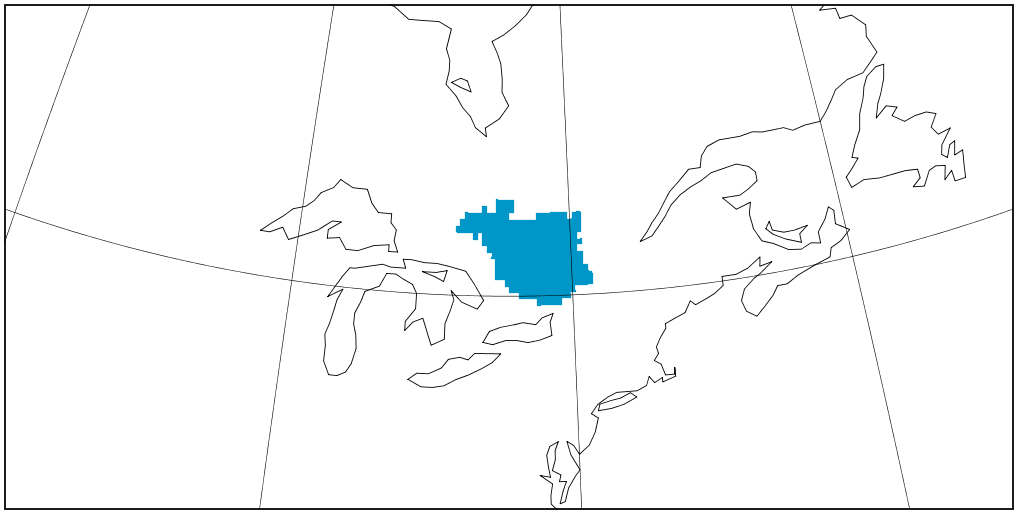

In [2]:
source = xr.open_dataset('DAYMET_1km_subset_BV_tmax_2017_01.nc4')
lat_source = source.variables['lat'][:]
lon_source = source.variables['lon'][:]
lat_source.shape

(678, 702)

In [5]:
source

<xarray.Dataset>
Dimensions:            (time: 31, x: 702, y: 678)
Coordinates:
  * x                  (x) float32 1276.75 1277.75 1278.75 ... 1976.75 1977.75
  * y                  (y) float32 992.0 991.0 990.0 989.0 ... 317.0 316.0 315.0
  * time               (time) datetime64[ns] 2017-01-01T12:00:00 ... 2017-01-31T12:00:00
Data variables:
    Lambert_Conformal  |S1 ...
    lat                (y, x) float32 ...
    lon                (y, x) float32 ...
    tmax               (time, y, x) float32 ...

## 3- Loading target file

We want to interpolate our source file on ERA5-grid. Let's load ERA5 reanalysis as target grid. 

In [182]:
target = xr.open_dataset('ERA5_Outaouais_daily_tmax_201701.nc')
lat_target=target.latitude
lon_target=target.longitude
lat_target.shape

(29,)

ERA5 latitude and longitude are 1D array dimension.  We must convert these 1-dimensional arrays into  2-dimensional arrays. 

In [183]:
lon_target2d, lat_target2d = np.meshgrid(lon_target, lat_target)
lon_target2d.shape

(29, 121)

This next function will be use for converting lat/lon to cartesian coordinates (x, y, z):

In [184]:
def lon_lat_to_cartesian(lon, lat):
    # WGS 84 reference coordinate system parameters
    A = 6378.137 # major axis [km]   
    E2 = 6.69437999014e-3 # eccentricity squared 
    
    lon_rad = np.radians(lon)
    lat_rad = np.radians(lat)
    # convert to cartesian coordinates
    r_n = A / (np.sqrt(1 - E2 * (np.sin(lat_rad) ** 2)))
    x = r_n * np.cos(lat_rad) * np.cos(lon_rad)
    y = r_n * np.cos(lat_rad) * np.sin(lon_rad)
    z = r_n * (1 - E2) * np.sin(lat_rad)
    return x,y,z

Now all necessary inputs are read in memory, we can now convert lat/lon to the Cartesian coordinate reference system (CRS):

In [185]:
xs, ys, zs = lon_lat_to_cartesian(lon_source.values.flatten(), lat_source.values.flatten())
xt, yt, zt = lon_lat_to_cartesian(lon_target2d.flatten(), lat_target2d.flatten())

## 4- Step1:  construct the cKDTree object 

We can then create a KD-tree with the set of points within which we want to search for a closest point in our source grid. 

In [189]:
tree = cKDTree(np.column_stack((xs, ys, zs)))

## 5- Step2: Interpolation on target grid

The second step provides a query point and returns the closest point or points in the KD-tree to the query point, where how "closest" is defined can be varied. 

Here, we use 3D points on spherical Earth with unit radius.

Two methods of interpolation are considered here: nearest neighbour and weighting with the inverse of distance squared.

### a- Nearest neighbour interpolation 

In this step, we find indices of the nearest neighbors in the flattened array using our 'tree' from step1.  To do this, we will apply
[cKDTree.query method](https://docs.scipy.org/doc/scipy-0.12.0/reference/generated/scipy.spatial.cKDTree.query.html#scipy.spatial.cKDTree.query)




In [190]:
#find indices of the nearest neighbors in the flattened array
#d, inds = tree.query(zip(xt, yt, zt), k = 1)
d, inds = tree.query(np.column_stack((xt, yt, zt)), k = 1)

We can now interpolate our 2d field using our index tree. We will interpolate our first timestep for daymet source file (ie datetime64[ns] 2017-01-01T12:00:00) 

In [192]:
source.tmax[0]

<xarray.DataArray 'tmax' (y: 678, x: 702)>
[475956 values with dtype=float32]
Coordinates:
  * x        (x) float32 1276.75 1277.75 1278.75 ... 1975.75 1976.75 1977.75
  * y        (y) float32 992.0 991.0 990.0 989.0 ... 318.0 317.0 316.0 315.0
    time     datetime64[ns] 2017-01-01T12:00:00
Attributes:
    long_name:     daily maximum temperature
    units:         degrees C
    grid_type:     lcc2
    grid_mapping:  Lambert_Conformal
    cell_methods:  area: mean time: maximum
    _ChunkSizes:   [   1 1000 1000]

In [193]:
#get interpolated 2d field
air_nearest = source.tmax[0].values.flatten()[inds].reshape(lon_target2d.shape)

### b- Interpolation using inverse distance weighting, using 10 nearest neighbours (k=10):

In [194]:
d, inds = tree.query(np.column_stack((xt, yt, zt)), k = 10)
w = 1.0 / d**2
air_idw = np.sum(w * source.tmax[0].values.flatten()[inds], axis=1) / np.sum(w, axis=1)
air_idw.shape = lon_target2d.shape

## 6- Plot the results:

Now let us plot the results from these two approaches. For ERA5-target grid, wi will apply a mask to visualize the same watershed. 
This mask was created using a shapefile. 

In [197]:
MASK = xr.open_dataset('Outaouais_ERA5_Grid.nc')
lat1d=MASK.variables['latitude'][:]
lon1d=MASK.variables['longitude'][:]
lon2d, lat2d = np.meshgrid(lon1d, lat1d)
mask = MASK['tp'][ :, :]

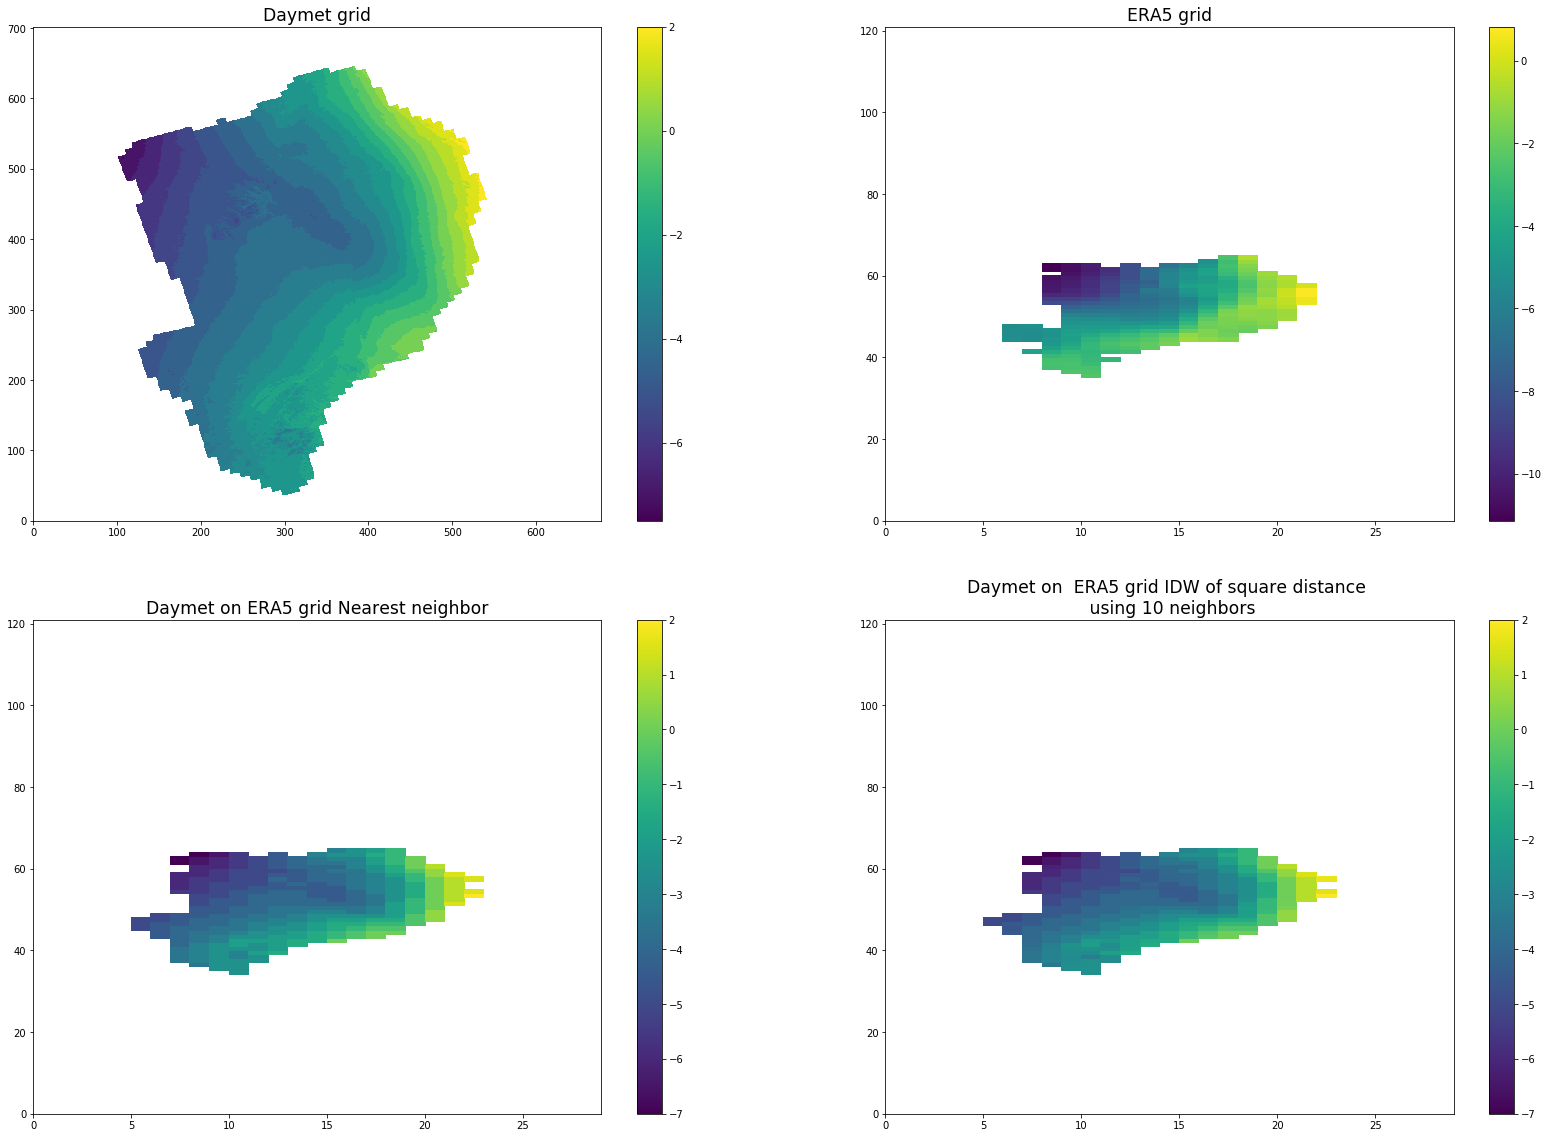

In [200]:
fig = plt.figure(figsize=(28,20))

subplot(221)
plt.pcolormesh(source.tmax[0,:,:].values.transpose())
plt.xlim([0, source.tmax[0,:,:].shape[0]])
plt.ylim([0, source.tmax[0,:,:].shape[1]])
plt.colorbar()
plt.title("Daymet grid", size='xx-large')

subplot(222)
plt.pcolormesh(target.t2m[0,:,:].where(mask.values>=0).values.transpose())
plt.xlim([0, target.t2m[0,:,:].shape[0]])
plt.ylim([0, target.t2m[0,:,:].shape[1]])
plt.colorbar()
plt.title("ERA5 grid", size='xx-large')

subplot(223)
plt.pcolormesh(air_nearest.transpose())
plt.xlim([0, air_nearest.shape[0]])
plt.ylim([0, air_nearest.shape[1]])
plt.colorbar()
plt.title("Daymet on ERA5 grid Nearest neighbor", size='xx-large')

subplot(224)
plt.pcolormesh(air_idw.transpose())
plt.colorbar()
plt.xlim([0, air_idw.shape[0]])
plt.ylim([0, air_idw.shape[1]])
plt.title("Daymet on  ERA5 grid IDW of square distance \n using 10 neighbors", size='xx-large');

This was a quick plot, let's make better plots using Cartopy library. 

We first define a function to create the map subplots:

In [201]:
def plot_background(ax):
    ax.set_extent([-82,-73,45,49])
    ax.coastlines(resolution='110m');
    ax.add_feature(cfeature.OCEAN.with_scale('50m'))      
    ax.add_feature(cfeature.LAND.with_scale('50m'))       
    ax.add_feature(cfeature.LAKES.with_scale('50m'))     
    ax.add_feature(cfeature.BORDERS.with_scale('50m'))    
    ax.add_feature(cfeature.RIVERS.with_scale('50m'))    
    coast = cfeature.NaturalEarthFeature(category='physical', scale='10m',    
                        facecolor='none', name='coastline')
    ax.add_feature(coast, edgecolor='black')
    
    states_provinces = cfeature.NaturalEarthFeature(
        category='cultural',
        name='admin_1_states_provinces_lines',
        scale='10m',
        facecolor='none')

    ax.add_feature(states_provinces, edgecolor='gray')

   
    return ax

We will plot the two different interpolations (a) and (b):

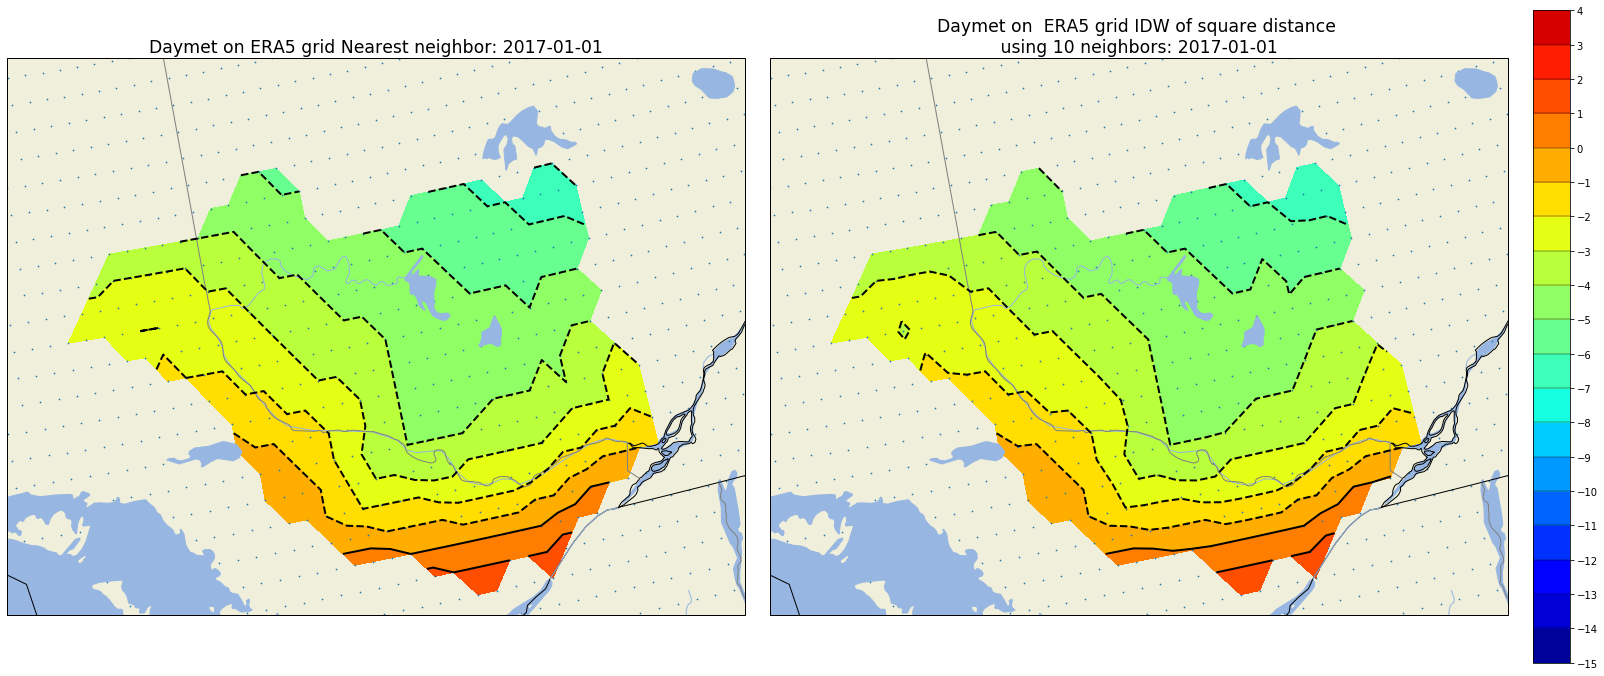

In [205]:
fig = plt.figure(figsize=(28,12))
from matplotlib.gridspec import GridSpec
cmap0=plt.cm.jet
cmap0.set_under('darkblue') 
cmap0.set_over('darkred')

gs = GridSpec(1,3, width_ratios=[1,1, 0.05], wspace = 0.05)
crs=ccrs.LambertConformal()
# Left plot - ERA5 grid Nearest neighbor
ax1 = plt.subplot(gs[0, 0], projection=crs)
plot_background(ax1)
ax1.contourf(lon_target2d,\
                   lat_target2d,\
                   air_nearest,\
                   vmin=-15,\
                   vmax=5, \
                   transform=ccrs.PlateCarree(),\
                   levels=np.arange(-15, 5, 1.0),\
                   cmap=cmap0 )
ax1.contour(lon_target2d, lat_target2d, air_nearest, 
                          levels = np.arange(-15, 5, 1.0), 
                          linewidths=2, 
                          colors='k',
                          transform = ccrs.PlateCarree())
ax1.scatter(lon_target2d, lat_target2d, transform=ccrs.PlateCarree(), s=0.5)
string_title=u'Daymet on ERA5 grid Nearest neighbor: 2017-01-01'
plt.title(string_title, size='xx-large')

# Right plot - ERA5 grid IDW of square distance 
ax2 = plt.subplot(gs[0, 1], projection=crs)

plot_background(ax2)
mm = ax2.contourf(lon_target2d,\
                   lat_target2d,\
                   air_idw,\
                   vmin=-15,\
                   vmax=5, \
                   transform=ccrs.PlateCarree(),\
                   levels=np.arange(-15, 5, 1.0),\
                   cmap=cmap0 )
ax2.contour(lon_target2d, lat_target2d, air_idw, 
                          levels = np.arange(-15, 5, 1.0), 
                          linewidths=2, 
                          colors='k',
                          transform = ccrs.PlateCarree())

ax2.scatter(lon_target2d, lat_target2d, transform=ccrs.PlateCarree(), s=0.5)
string_title=u'Daymet on  ERA5 grid IDW of square distance \n using 10 neighbors: 2017-01-01 '
plt.title(string_title, size='xx-large')
ax = fig.add_subplot(gs[0,2])
plt.colorbar(mm,  shrink=0.75, drawedges='True', ticks=np.arange(-15, 5.1, 1.), extend='both', cax = ax)
cbar.ax.tick_params(labelsize=20) 


We plot Daymet-1km and ERA5 datasets for the same date: 2017-01-01

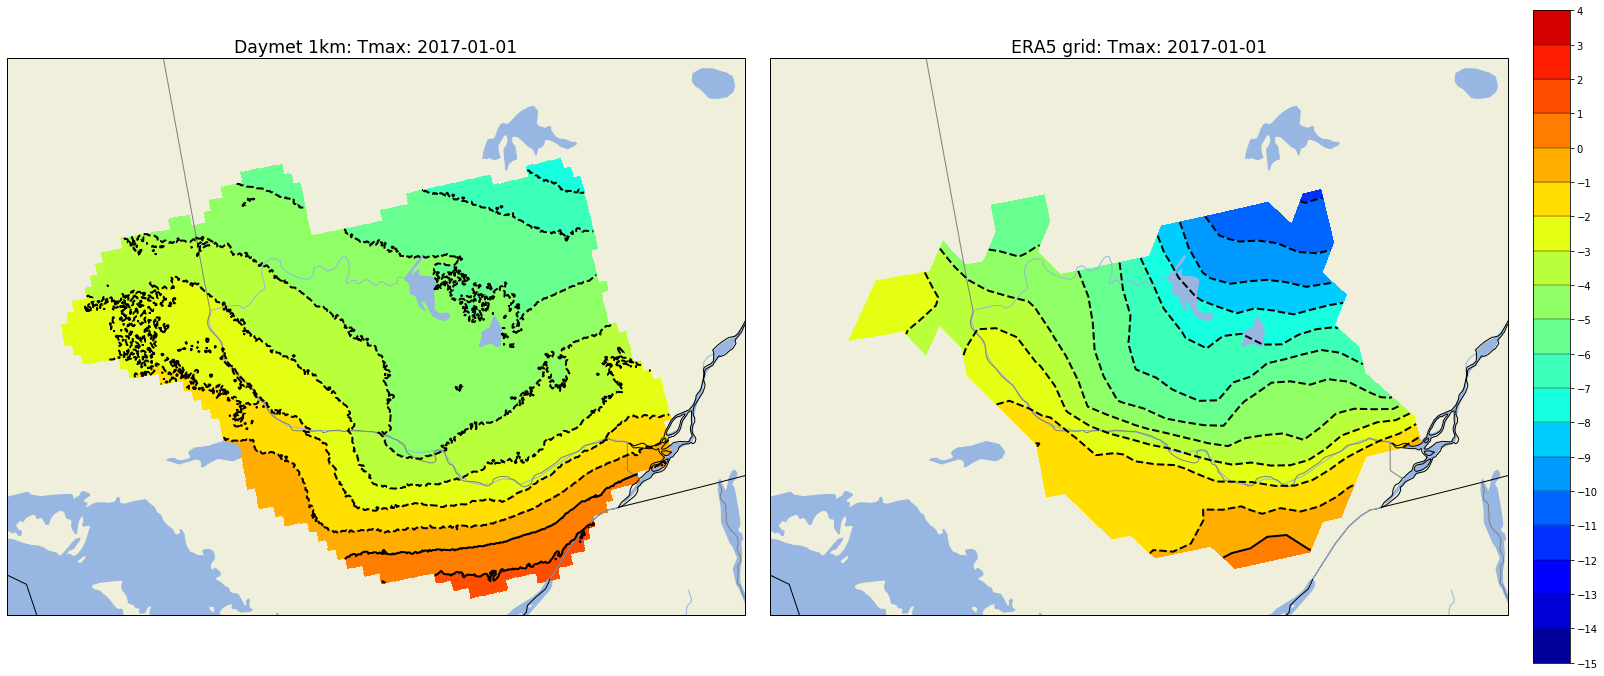

In [209]:
fig = plt.figure(figsize=(28,12))
from matplotlib.gridspec import GridSpec
cmap0=plt.cm.jet
cmap0.set_under('darkblue') 
cmap0.set_over('darkred')

gs = GridSpec(1,3, width_ratios=[1,1, 0.05], wspace = 0.05)
crs=ccrs.LambertConformal()
# Left plot: Daymet: source grid
ax1 = plt.subplot(gs[0, 0], projection=crs)
plot_background(ax1)
ax1.contourf(lon_s,\
                   lat_s,\
                   source.tmax[0,:,:],\
                   vmin=-15,\
                   vmax=5, \
                   transform=ccrs.PlateCarree(),\
                   levels=np.arange(-15, 5, 1.0),\
                   cmap=cmap0 )
ax1.contour(lon_s, lat_s, source.tmax[0,:,:], 
                          levels = np.arange(-15, 5, 1.0), 
                          linewidths=2, 
                          colors='k',
                          transform = ccrs.PlateCarree())
string_title=u'Daymet 1km: Tmax: 2017-01-01'
plt.title(string_title, size='xx-large')

# Right plot: ERA5: target grid
ax2 = plt.subplot(gs[0, 1], projection=crs)

plot_background(ax2)
mm = ax2.contourf(lon_target2d,\
                   lat_target2d,\
                   target.t2m[0,:,:].where(mask.values>=0),\
                   vmin=-15,\
                   vmax=5, \
                   transform=ccrs.PlateCarree(),\
                   levels=np.arange(-15, 5, 1.0),\
                   cmap=cmap0 )
ax2.contour(lon_target2d, lat_target2d, target.t2m[0,:,:].where(mask.values>=0), 
                          levels = np.arange(-15, 5, 1.0), 
                          linewidths=2, 
                          colors='k',
                          transform = ccrs.PlateCarree())
string_title=u'ERA5 grid: Tmax: 2017-01-01'
plt.title(string_title, size='xx-large')
ax = fig.add_subplot(gs[0,2])
plt.colorbar(mm,  shrink=0.75, drawedges='True', ticks=np.arange(-15, 5.1, 1.), extend='both', cax = ax)
cbar.ax.tick_params(labelsize=50) 

## 7- Saving Netcdf files with every daily timesteps:

We can work and interpolate for one timestep (ie 2017-01-01). We can now create a function to interpolate every timesteps of our source grid on target grid and then save the result array into netcdf file. 

In [211]:
d, inds = tree.query(np.column_stack((xt, yt, zt)), k = 10)
w = 1.0 / d**2

In [219]:
def interpolate(source, target, d, inds):    
    nt = source["time"].shape[0]
    tmp = []
    for t in range(0, nt):        
        result = np.zeros(target.shape)
        w = 1.0 / d**2
        air_idw = np.sum(w * source.tmax[t].values.flatten()[inds], axis=1) / np.sum(w, axis=1)
        air_idw.shape = target.shape
        tmp.append(air_idw)
    return tmp

In [226]:
source = xr.open_dataset('DAYMET_1km_subset_BV_tmax_2017_01.nc4')
target = xr.open_dataset('ERA5_Outaouais_daily_tmax_201701.nc')
lon_target=target.longitude
lat_target=target.latitude
lon_target2d, lat_target2d = np.meshgrid(lon_target, lat_target)

air_idw = interpolate(source,lon_target2d, d, inds)


We can now save our numpy array to xarray and then into netcdf file. 

In [228]:
data_set = xr.Dataset( coords={'lon': ([ 'lon'], lon_target),
                                     'lat': (['lat',], lat_target),
                                     'time': source.time.values})
data_set["tasmax"] = (['time','lat', 'lon'],  air_idw)

In [229]:
data_set.to_netcdf('DAYMET_32km_subset_BV_tmax_2017_01.nc')

In [230]:
data_set

<xarray.Dataset>
Dimensions:  (lat: 29, lon: 121, time: 31)
Coordinates:
  * lon      (lon) float32 270.0 270.25 270.5 270.75 ... 299.5 299.75 300.0
  * lat      (lat) float32 50.0 49.75 49.5 49.25 49.0 ... 43.75 43.5 43.25 43.0
  * time     (time) datetime64[ns] 2017-01-01T12:00:00 ... 2017-01-31T12:00:00
Data variables:
    tasmax   (time, lat, lon) float64 nan nan nan nan nan ... nan nan nan nan

## 